In [1]:
%matplotlib notebook
import os
import h5py
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from csbdeep.utils import plot_history
import obspy
import shutil
import numpy.ma as ma
import scipy.signal as signal
import numpy as np
from random import randint
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
import random

In [59]:
with open('list_noisy_arrays.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing = [str(item) for item in list_of_strings if item]

In [60]:
data=np.zeros((100,640,2048))
for i in range(100):
    data[i]=np.load(listing[i+170])

In [61]:
fs = 4000  # Sampling frequency

In [64]:
def load_data(data):
    # defining the input image size 
    input_image = Input(shape =(128, 16, 2))
    fs = 4000  # Sampling frequency
    t = np.arange(1921)/ fs
    X_train=np.zeros((90*data.shape[1],128,16,2))
    noise_mask_train=np.zeros((90*data.shape[1],128,16,1))
    signal_mask_train=np.zeros((90*data.shape[1],128,16,1))
    X_test=np.zeros((10*data.shape[1],128,16,2))
    noise_mask_test=np.zeros((10*data.shape[1],128,16,1))
    signal_mask_test=np.zeros((10*data.shape[1],128,16,1))
    log_SNR_max = 4
    log_SNR_min = 0
    rng = np.random.default_rng()
    for j in range(90):
        for i in range(data.shape[1]):
            SNR = rng.random() * (log_SNR_max - log_SNR_min) + log_SNR_min
            SNR = 10**(0.5 * SNR)
            amp = 2 * SNR / np.abs(data[j,i]).max()

            # Generate the sinusoids
            num_sinusoids = random.randint(1, 3)
            freqs = np.random.uniform(1, fs/2, size=num_sinusoids)
            amps = amp * np.random.uniform(0.1, 1, size=num_sinusoids)
            phases = np.random.uniform(0, 2*np.pi, size=num_sinusoids)
            sinusoids = [amp*np.sin(2 * np.pi * freq * t + phase) for amp, freq, phase in zip(amps, freqs, phases)]

            # Add the sinusoids together
            sinusoid = np.sum(sinusoids, axis=0)
            sinusoid *= amp / np.abs(sinusoid).max()
            #Apply data augmentation
            reverse = np.random.randint(low=0, high=2)
            flip = np.random.randint(low=0, high=2)
            move_out = np.random.randint(low=0, high=2)
            if reverse:
                data[j,i] = np.flip(data[j,i], axis=0)
            if flip:
                data[j,i] = np.multiply(data[j,i], -1)
            if move_out:
                shift = np.random.randint(low=0, high=1921)
                data[j,i] = np.roll(data[j,i], shift=shift, axis=0)
            #Compute masks
            start_idx = np.random.randint(0, data.shape[2] - 1921)
            _, _, S_tf = signal.stft(data[j,i,start_idx:start_idx+1921], fs=fs, nperseg=255)
            _, _, N_tf = signal.stft(sinusoid, fs=fs, nperseg=255)
            Y_tf=S_tf+N_tf
            noise_mask_train[j*data.shape[1]+i,:,:,0] = (np.abs(N_tf)/np.abs(S_tf))/(1+np.abs(N_tf)/np.abs(S_tf))
            signal_mask_train[j*data.shape[1]+i,:,:,0] = 1/(1+np.abs(N_tf)/np.abs(S_tf))
            X_train[j*data.shape[1]+i,:,:,0]=np.abs(Y_tf)
            X_train[j*data.shape[1]+i,:,:,1]=np.angle(Y_tf)
    for j in range(10):
        for i in range(data.shape[1]):
            SNR = rng.random() * (log_SNR_max - log_SNR_min) + log_SNR_min
            SNR = 10**(0.5 * SNR)
            amp = 2 * SNR / np.abs(data[90+j,i]).max()

            # Generate the sinusoids
            num_sinusoids = random.randint(1, 3)
            freqs = np.random.uniform(1, fs/2, size=num_sinusoids)
            amps = amp * np.random.uniform(0.1, 1, size=num_sinusoids)
            phases = np.random.uniform(0, 2*np.pi, size=num_sinusoids)
            sinusoids = [amp*np.sin(2 * np.pi * freq * t + phase) for amp, freq, phase in zip(amps, freqs, phases)]

            # Add the sinusoids together
            sinusoid = np.sum(sinusoids, axis=0)
            sinusoid *= amp / np.abs(sinusoid).max()
            #Apply data augmentation
            reverse = np.random.randint(low=0, high=2)
            flip = np.random.randint(low=0, high=2)
            move_out = np.random.randint(low=0, high=2)
            if reverse:
                data[90+j,i] = np.flip(data[90+j,i], axis=0)
            if flip:
                data[90+j,i] = np.multiply(data[90+j,i], -1)
            if move_out:
                shift = np.random.randint(low=0, high=1921)
                data[90+j,i] = np.roll(data[90+j,i], shift=shift, axis=0)
            # Compute masks
            start_idx = np.random.randint(0, data.shape[2] - 1921)
            _, _, S_tf = signal.stft(data[90+j,i,start_idx:start_idx+1921], fs=fs, nperseg=255)
            _, _, N_tf = signal.stft(sinusoid, fs=fs, nperseg=255)
            Y_tf=S_tf+N_tf
            noise_mask_test[j*data.shape[1]+i,:,:,0] = (np.abs(N_tf)/np.abs(S_tf))/(1+np.abs(N_tf)/np.abs(S_tf))
            signal_mask_test[j*data.shape[1]+i,:,:,0] = 1/(1+np.abs(N_tf)/np.abs(S_tf))
            X_test[j*data.shape[1]+i,:,:,0]=np.abs(Y_tf)
            X_test[j*data.shape[1]+i,:,:,1]=np.angle(Y_tf)
    return X_train,X_test,noise_mask_train,signal_mask_train,noise_mask_test,signal_mask_test,input_image

In [65]:
data.shape

(100, 640, 2048)

In [66]:
X_train,X_test,noise_mask_train,signal_mask_train,noise_mask_test,signal_mask_test,input_image = load_data(data)

<IPython.core.display.Javascript object>


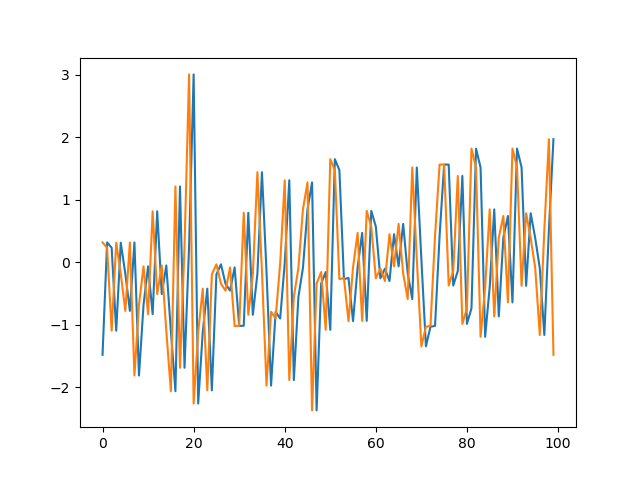

In [67]:
#Apply data augmentation
augmented_data = np.copy(data[0,0,0:100])
shift = -1
augmented_data = np.roll(augmented_data, shift=shift, axis=0)
plt.figure()
plt.plot(data[0,0,0:100], label='sinus')
plt.plot(augmented_data, label='sinus')

In [68]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GaussianDropout

def build_network(input_image):
    shape =(128, 16, 2) 
    # Building the encoder of the Auto-encoder
    x = Conv2D(16, (3, 3), activation ='relu', padding ='same')(input_image)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x_prev = [x]
    x = MaxPooling2D((2, 2), padding ='same')(x)
    x = Conv2D(32, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = Conv2D(64, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x_prev.append(x)
    x = MaxPooling2D((2, 2), padding ='same')(x)
    x = Conv2D(16, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    encoded_layer = Conv2D(8, (3, 3), activation ='relu', padding ='same')(x)
      
    # Building the decoder of the Auto-encoder
    x = Conv2D(16, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = Conv2D(32, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, x_prev[-1]])
    x = Conv2D(48, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = Conv2D(32, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = Conv2D(16, (3, 3), activation ='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = GaussianDropout(0.1)(x)
    x = concatenate([x, x_prev[-2]])
    decoded_layer = Conv2D(2, (3, 3), activation ='linear', padding ='same')(x)
    signal_mask = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_layer)
    noise_mask = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_layer)  
    return signal_mask, noise_mask
input_image = Input(shape=(128, 16, 2))
signal_mask, noise_mask = build_network(input_image)
autoencoder = Model(inputs=input_image, outputs=[signal_mask, noise_mask])

In [69]:
decoded_layer = build_network(input_image)

In [70]:
autoencoder.summary()
autoencoder.compile(optimizer ='adam', loss ='binary_crossentropy')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 16, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 16, 16)  304         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 128, 16, 16)  64         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                            

 batch_normalization_28 (BatchN  (None, 128, 16, 16)  64         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 gaussian_dropout_28 (GaussianD  (None, 128, 16, 16)  0          ['batch_normalization_28[0][0]'] 
 ropout)                                                                                          
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 16, 16)  2320        ['gaussian_dropout_28[0][0]']    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 128, 16, 16)  64         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
          

In [71]:
tf.keras.utils.plot_model(autoencoder)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [72]:
history=autoencoder.fit(X_train, [signal_mask_train, noise_mask_train],
                epochs=40,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, [signal_mask_test, noise_mask_test]))

Epoch 1/40
1800/1800 [==============================] - 630s 346ms/step - loss: 0.3322 - conv2d_40_loss: 0.1668 - conv2d_41_loss: 0.1654 - val_loss: 0.2945 - val_conv2d_40_loss: 0.1472 - val_conv2d_41_loss: 0.1473
Epoch 2/40
1800/1800 [==============================] - 623s 346ms/step - loss: 0.2924 - conv2d_40_loss: 0.1462 - conv2d_41_loss: 0.1462 - val_loss: 0.2894 - val_conv2d_40_loss: 0.1447 - val_conv2d_41_loss: 0.1447
Epoch 3/40
1800/1800 [==============================] - 626s 348ms/step - loss: 0.2875 - conv2d_40_loss: 0.1438 - conv2d_41_loss: 0.1438 - val_loss: 0.2847 - val_conv2d_40_loss: 0.1423 - val_conv2d_41_loss: 0.1424
Epoch 4/40
1800/1800 [==============================] - 625s 347ms/step - loss: 0.2845 - conv2d_40_loss: 0.1423 - conv2d_41_loss: 0.1423 - val_loss: 0.2825 - val_conv2d_40_loss: 0.1412 - val_conv2d_41_loss: 0.1413
Epoch 5/40
1800/1800 [==============================] - 627s 348ms/step - loss: 0.2824 - conv2d_40_loss: 0.1412 - conv2d_41_loss: 0.1412 - val_l

['conv2d_40_loss', 'conv2d_41_loss', 'loss', 'val_conv2d_40_loss', 'val_conv2d_41_loss', 'val_loss']


<IPython.core.display.Javascript object>


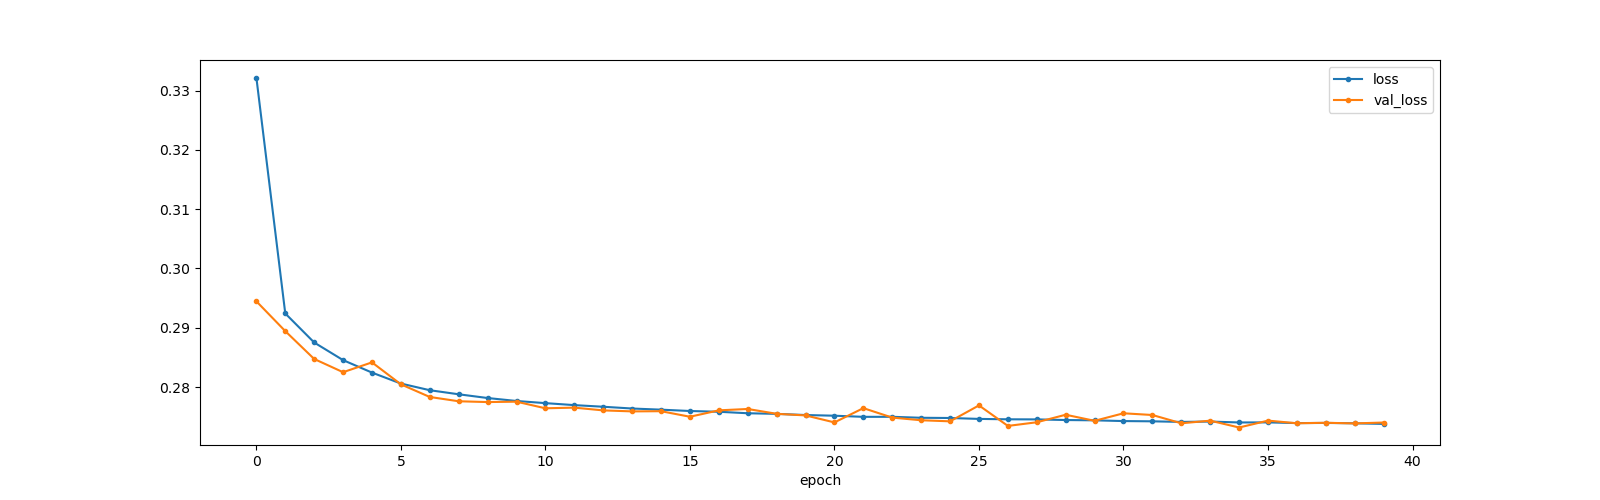

In [77]:
autoencoder.save('model_time_frequency_noisy_inputs.h5')
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);
plt.savefig("figures/model_time_frequency_noisy_inputs.pdf")

In [78]:
log_SNR_max = 4
log_SNR_min = 0
rng = np.random.default_rng()
fs = 4000  # Sampling frequency
t = np.arange(1921)/ fs
time_clean_inputs=np.zeros((640,2048))
stft_inputs=np.zeros((640,128,16,2))
ideal_signal_reconstruction=np.zeros((640,1921))
ideal_noise_reconstruction=np.zeros((640,1921))
time_clean_inputs=np.load(listing[0])
for i in range(time_clean_inputs.shape[0]):
    SNR = rng.random() * (log_SNR_max - log_SNR_min) + log_SNR_min
    SNR = 10**(0.5 * SNR)
    amp = 2 * SNR / np.abs(time_clean_inputs[i]).max()

    # Generate the sinusoids
    num_sinusoids = random.randint(1, 3)
    freqs = np.random.uniform(1, fs, size=num_sinusoids)
    amps = amp * np.random.uniform(0.1, 1, size=num_sinusoids)
    phases = np.random.uniform(0, 2*np.pi, size=num_sinusoids)
    sinusoids = [amp*np.sin(2 * np.pi * freq * t + phase) for amp, freq, phase in zip(amps, freqs, phases)]

    # Add the sinusoids together
    sinusoid = np.sum(sinusoids, axis=0)
    sinusoid *= amp / np.abs(sinusoid).max()
    #Apply data augmentation
    reverse = np.random.randint(low=0, high=2)
    flip = np.random.randint(low=0, high=2)
    move_out = np.random.randint(low=0, high=2)
    if reverse:
        time_clean_inputs[i] = np.flip(time_clean_inputs[i], axis=0)
    if flip:
        time_clean_inputs[i] = np.multiply(time_clean_inputs[i], -1)
    if move_out:
        shift = np.random.randint(low=0, high=1921)
        time_clean_inputs[i] = np.roll(time_clean_inputs[i], shift=shift, axis=0)
    start_idx = np.random.randint(0, time_clean_inputs.shape[1] - 1921)
    _, _, S_tf = signal.stft(time_clean_inputs[i,start_idx:start_idx+1921], fs=fs, nperseg=255)
    _, _, N_tf = signal.stft(sinusoid, fs=fs, nperseg=255)
    Y_tf=S_tf+N_tf
    stft_inputs[i,:,:,0]=np.abs(Y_tf)
    stft_inputs[i,:,:,1]=np.angle(Y_tf)
    _, ideal_signal_reconstruction[i] = signal.istft(S_tf, fs=fs, nperseg=255)
    _, ideal_noise_reconstruction[i] = signal.istft(N_tf, fs=fs, nperseg=255)

In [79]:
[signal_mask,noise_mask]=autoencoder.predict(stft_inputs)

20/20 [==============================] - 1s 51ms/step


<IPython.core.display.Javascript object>


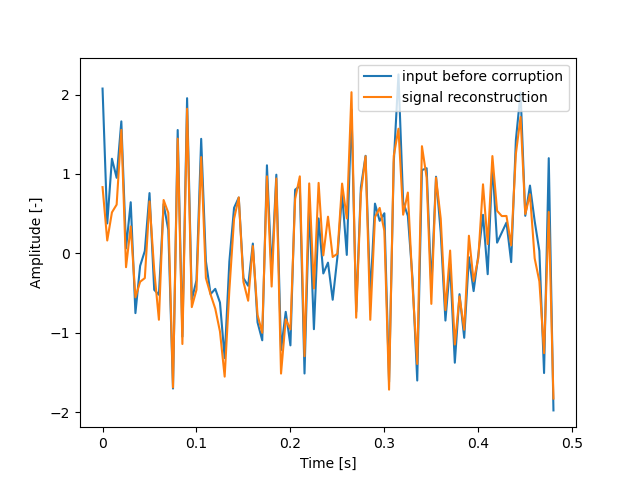

<IPython.core.display.Javascript object>


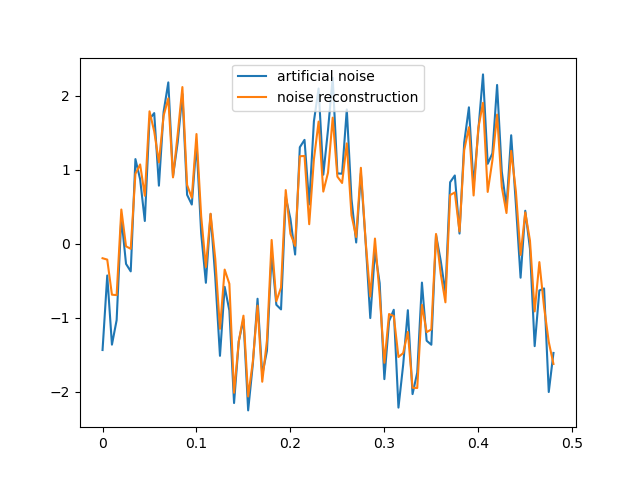

<IPython.core.display.Javascript object>


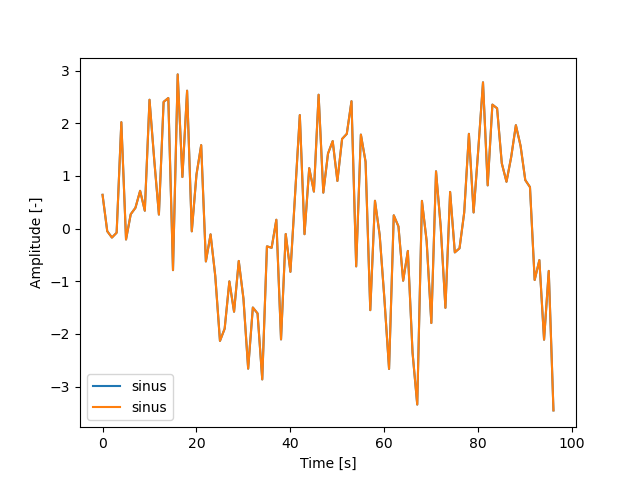

In [80]:
_, time_input= signal.istft(stft_inputs[0,:,:,0]*np.exp(1j*stft_inputs[0,:,:,1]), fs=fs, nperseg=255)
_, autoencoder_signal_recon = signal.istft(stft_inputs[0,:,:,0]*signal_mask[0,:,:,0]*np.exp(1j*stft_inputs[0,:,:,1]), fs=fs, nperseg=255)
plt.figure()
plt.plot(ideal_signal_reconstruction[0,0:1921:20], label='input before corruption')
plt.plot(autoencoder_signal_recon[0:1921:20], label='signal reconstruction')
_, autoencoder_noise_recon = signal.istft(stft_inputs[0,:,:,0]*noise_mask[0,:,:,0]*np.exp(1j*stft_inputs[0,:,:,1]), fs=fs, nperseg=255)
plt.legend()
plt.xlabel('Time [s]')  
plt.ylabel('Amplitude [-]') 
xticks, xtick_labels = plt.xticks()
xticks_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.xticks(xticks[1:7], xticks_labels)
plt.savefig("figures/signal reconstrucion.pdf")
plt.figure()
plt.plot(ideal_noise_reconstruction[0,0:1921:20], label='artificial noise')
plt.plot(autoencoder_noise_recon[0:1921:20], label='noise reconstruction')
plt.legend()
xticks, xtick_labels = plt.xticks()
xticks_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.xticks(xticks[1:7], xticks_labels)
plt.savefig("figures/noise reconstrucion.pdf")
signal_and_noise_recon=autoencoder_noise_recon+autoencoder_signal_recon
plt.figure()
plt.plot(signal_and_noise_recon[0:1921:20], label='sinus')
plt.plot(time_input[0:1921:20], label='sinus')
plt.xlabel('Time [s]')  
plt.ylabel('Amplitude [-]') 
plt.legend()

In [81]:
with open('my_list.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
clean_list = [str(item) for item in list_of_strings if item]

In [83]:
clean_inputs=np.load(clean_list[70])[:,100:2021]
test_stft_input=np.zeros((640,128,16,2))
for i in range(clean_inputs.shape[0]):
    _, _, Y_tf = signal.stft(clean_inputs[i], fs=fs, nperseg=255)
    test_stft_input[i,:,:,0]=np.abs(Y_tf)
    test_stft_input[i,:,:,1]=np.angle(Y_tf)

20/20 [==============================] - 1s 58ms/step


<IPython.core.display.Javascript object>


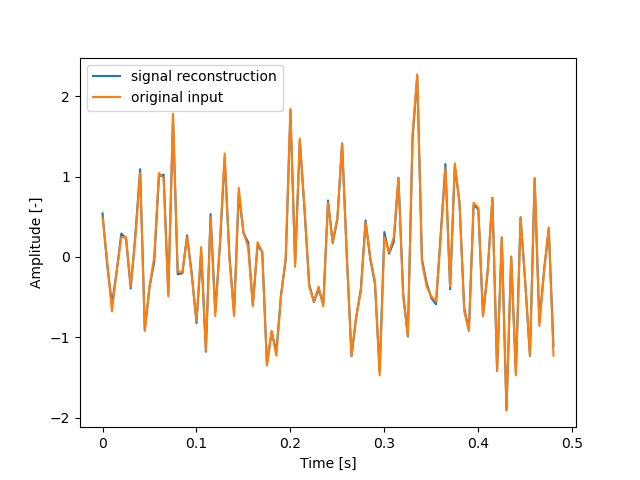

<IPython.core.display.Javascript object>


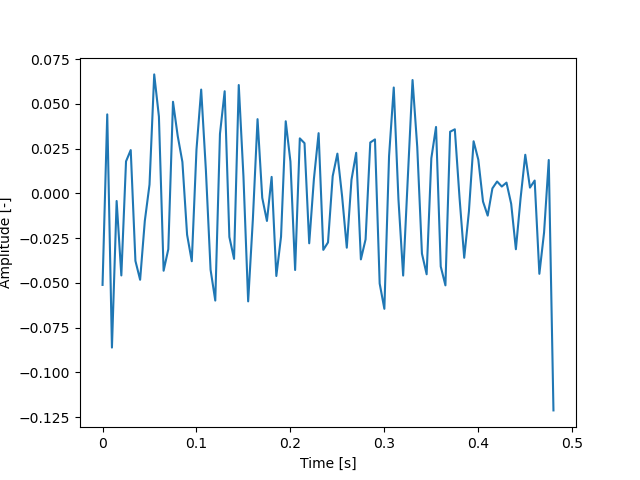

In [101]:
[signal_mask,noise_mask]=autoencoder.predict(test_stft_input)
_, autoencoder_signal_recon = signal.istft(test_stft_input[200,:,:,0]*signal_mask[200,:,:,0]*np.exp(1j*test_stft_input[200,:,:,1]), fs=fs, nperseg=255)
plt.figure()
plt.plot(autoencoder_signal_recon[0:1921:20], label='signal reconstruction')
_, dummy = signal.istft(test_stft_input[200,:,:,0]*np.exp(1j*test_stft_input[200,:,:,1]), fs=fs, nperseg=255)
plt.plot(dummy[0:1921:20], label='original input')
plt.legend()
_, autoencoder_noise_recon = signal.istft(test_stft_input[200,:,:,0]*noise_mask[200,:,:,0]*np.exp(1j*test_stft_input[200,:,:,1]), fs=fs, nperseg=255)
plt.xlabel('Time [s]')  
plt.ylabel('Amplitude [-]') 
plt.savefig("figures/signal_of_clean_input.pdf")
xticks, xtick_labels = plt.xticks()
xticks_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.xticks(xticks[1:7], xticks_labels)
plt.figure()
plt.plot(autoencoder_noise_recon[0:1921:20], label='noise reconstruction')
plt.xlabel('Time [s]')  
plt.ylabel('Amplitude [-]')
xticks, xtick_labels = plt.xticks()
xticks_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.xticks(xticks[1:7], xticks_labels)
plt.savefig("figures/noise_of_clean_input.pdf")

In [97]:
signal_power = np.mean(np.square(autoencoder_signal_recon[0:1921]))
noise_power = np.mean(np.square(autoencoder_noise_recon[0:1921]))
snr = 10 * np.log10(signal_power / noise_power)
print(snr)

26.833264486392622
